# Lead Scoring Solution

In [1]:
import shap
import joblib

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.stats import zscore, shapiro, kstest

from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV


/Users/ricardocosta/miniconda3/envs/lead-score/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def calculate_class_distribution(y: np.ndarray, dataset_name: str) -> None:
    """
    Calculate and print the class distribution of the target variable.

    Parameters:
    - y (np.ndarray): The target variable array.
    - dataset_name (str): The name of the dataset for labeling the output.

    Returns:
    - None
    """
    total_count = len(y)
    count_0 = (y == 0).sum()
    count_1 = (y == 1).sum()

    percentage_0 = (count_0 / total_count) * 100
    percentage_1 = (count_1 / total_count) * 100

    print(f'{dataset_name} - 0 Percentage: {percentage_0:.2f}%')
    print(f'{dataset_name} - 1 Percentage: {percentage_1:.2f}%')

    sns.histplot(y, kde=False)
    plt.title(f'Class Distribution in {dataset_name}')
    plt.xlabel('Converted')
    plt.ylabel('Frequency')
    plt.show()

def print_classification_metrics(y_true: np.ndarray, y_pred: np.ndarray, y_pred_proba: np.ndarray, dataset_name: str) -> None:
    """
    Calculate and print classification metrics for the model predictions.

    Parameters:
    - y_true (np.ndarray): True labels.
    - y_pred (np.ndarray): Predicted labels.
    - y_pred_proba (np.ndarray): Predicted probabilities for the positive class.
    - dataset_name (str): The name of the dataset for labeling the output.

    Returns:
    - None
    """
    accuracy = accuracy_score(y_true, y_pred)
    roc_auc = roc_auc_score(y_true, y_pred_proba)
    confusion = confusion_matrix(y_true, y_pred)
    report = classification_report(y_true, y_pred, output_dict=True)
    precision = report['1']['precision']
    recall = report['1']['recall']
    f1_score = report['1']['f1-score']

    print(f'{dataset_name} - Accuracy: {accuracy:.2f}')
    print(f'{dataset_name} - ROC-AUC: {roc_auc:.2f}')
    print(f'{dataset_name} - Confusion Matrix:\n{confusion}')
    print(f'{dataset_name} - Precision: {precision:.2f}')
    print(f'{dataset_name} - Recall: {recall:.2f}')
    print(f'{dataset_name} - F1-Score: {f1_score:.2f}')
    print()

def log_odds_to_probability(log_odds: float) -> float:
    """
    Convert log-odds to probability.

    Parameters:
    - log_odds (float): The log-odds value to be converted.

    Returns:
    - float: The corresponding probability.
    """
    return 1 / (1 + np.exp(-log_odds))

In [3]:
# Load the lead scoring data, correcting for the proper delimiter and skipping the wrong initial line
lead_scoring_path = '../data/lead_scoring.csv'
lead_data = pd.read_csv(lead_scoring_path, delimiter=';', skiprows=1)

# Initial data exploration
print(lead_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9240 entries, 0 to 9239
Data columns (total 37 columns):
 #   Column                                         Non-Null Count  Dtype  
---  ------                                         --------------  -----  
 0   Prospect ID                                    9240 non-null   object 
 1   Lead Number                                    9240 non-null   int64  
 2   Lead Origin                                    9240 non-null   object 
 3   Lead Source                                    9204 non-null   object 
 4   Do Not Email                                   9240 non-null   object 
 5   Do Not Call                                    9240 non-null   object 
 6   Converted                                      9240 non-null   int64  
 7   TotalVisits                                    9103 non-null   float64
 8   Total Time Spent on Website                    9240 non-null   int64  
 9   Page Views Per Visit                           9103 

In [4]:
print(lead_data.head())

                            Prospect ID  Lead Number              Lead Origin  \
0  7927b2df-8bba-4d29-b9a2-b6e0beafe620       660737                      API   
1  2a272436-5132-4136-86fa-dcc88c88f482       660728                      API   
2  8cc8c611-a219-4f35-ad23-fdfd2656bd8a       660727  Landing Page Submission   
3  0cc2df48-7cf4-4e39-9de9-19797f9b38cc       660719  Landing Page Submission   
4  3256f628-e534-4826-9d63-4a8b88782852       660681  Landing Page Submission   

      Lead Source Do Not Email Do Not Call  Converted  TotalVisits  \
0      Olark Chat           No          No          0          0.0   
1  Organic Search           No          No          0          5.0   
2  Direct Traffic           No          No          1          2.0   
3  Direct Traffic           No          No          0          1.0   
4          Google           No          No          1          2.0   

   Total Time Spent on Website  Page Views Per Visit  ...  \
0                            0 

### Missing Values Analysis

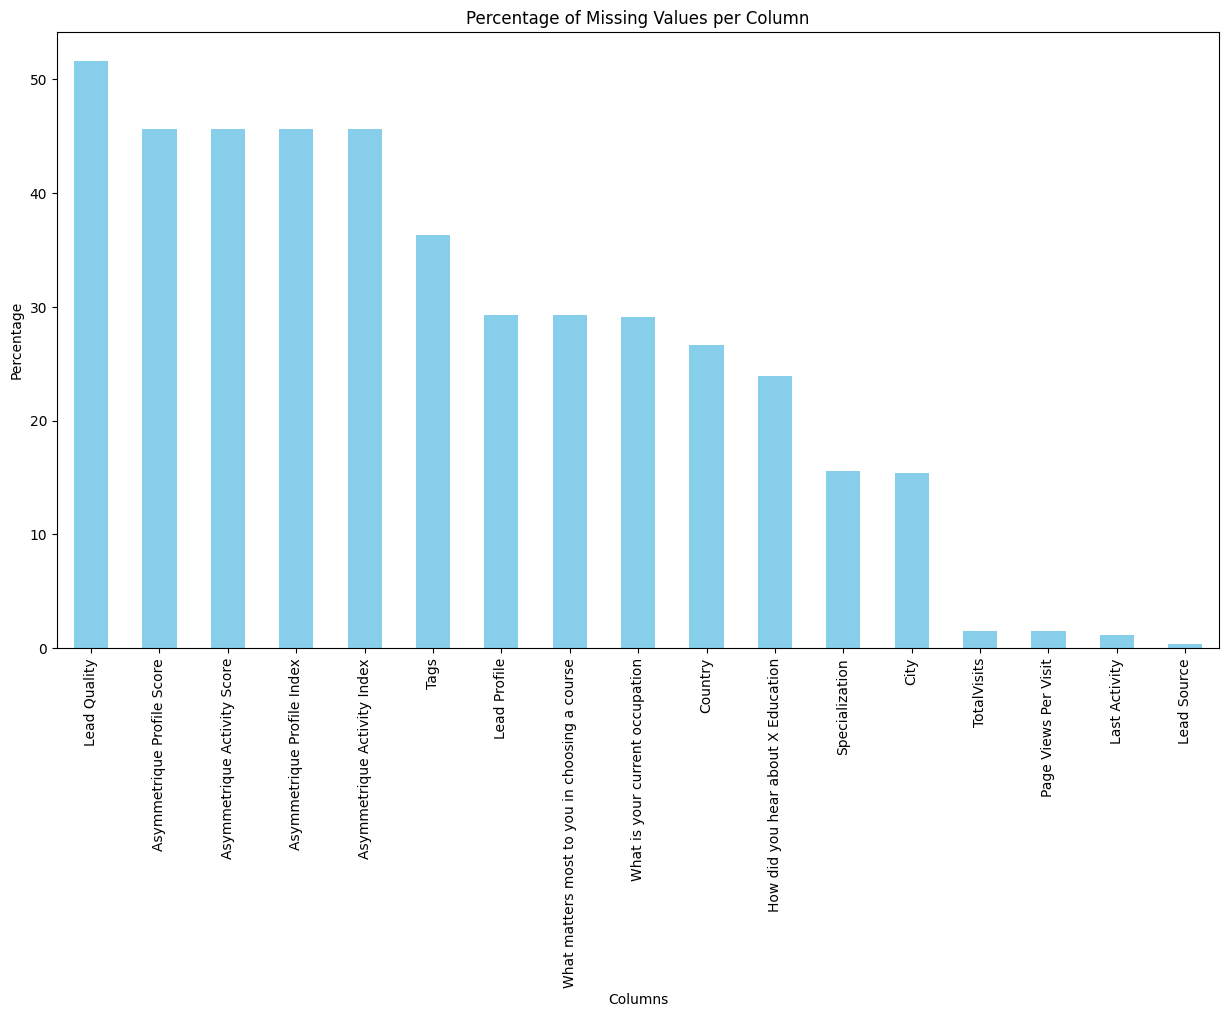

In [5]:
# Checking missing values percentages
missing_data_percentage = lead_data.isnull().sum() / len(lead_data) * 100

# Visualizing missing data
plt.figure(figsize=(15, 8))
missing_data_percentage[missing_data_percentage > 0].sort_values(ascending=False).plot.bar(color='skyblue')
plt.title('Percentage of Missing Values per Column')
plt.xlabel('Columns')
plt.ylabel('Percentage')
plt.show()

In [6]:
# Dropping columns with more than 30% missing data
columns_to_drop = missing_data_percentage[missing_data_percentage > 30].index
lead_data_cleaned = lead_data.drop(columns=columns_to_drop)

print(f'Columns Dropped: {columns_to_drop}')

Columns Dropped: Index(['Tags', 'Lead Quality', 'Asymmetrique Activity Index',
       'Asymmetrique Profile Index', 'Asymmetrique Activity Score',
       'Asymmetrique Profile Score'],
      dtype='object')


In [7]:
# Dropping rows with any missing values
lead_data_dropped = lead_data_cleaned.dropna()

In [8]:
# Confirming the cleaned dataset
print(lead_data_dropped.info())
print(lead_data_dropped.head())

<class 'pandas.core.frame.DataFrame'>
Index: 4925 entries, 1 to 9239
Data columns (total 31 columns):
 #   Column                                         Non-Null Count  Dtype  
---  ------                                         --------------  -----  
 0   Prospect ID                                    4925 non-null   object 
 1   Lead Number                                    4925 non-null   int64  
 2   Lead Origin                                    4925 non-null   object 
 3   Lead Source                                    4925 non-null   object 
 4   Do Not Email                                   4925 non-null   object 
 5   Do Not Call                                    4925 non-null   object 
 6   Converted                                      4925 non-null   int64  
 7   TotalVisits                                    4925 non-null   float64
 8   Total Time Spent on Website                    4925 non-null   int64  
 9   Page Views Per Visit                           4925 non-n

In [9]:
lead_data_dropped.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4925 entries, 1 to 9239
Data columns (total 31 columns):
 #   Column                                         Non-Null Count  Dtype  
---  ------                                         --------------  -----  
 0   Prospect ID                                    4925 non-null   object 
 1   Lead Number                                    4925 non-null   int64  
 2   Lead Origin                                    4925 non-null   object 
 3   Lead Source                                    4925 non-null   object 
 4   Do Not Email                                   4925 non-null   object 
 5   Do Not Call                                    4925 non-null   object 
 6   Converted                                      4925 non-null   int64  
 7   TotalVisits                                    4925 non-null   float64
 8   Total Time Spent on Website                    4925 non-null   int64  
 9   Page Views Per Visit                           4925 non-n

### Outlier Analysis

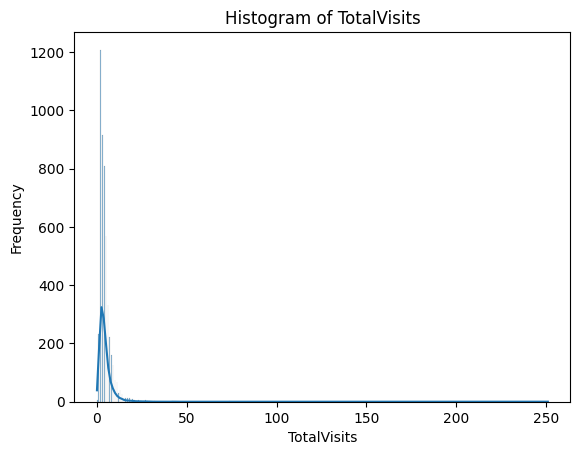

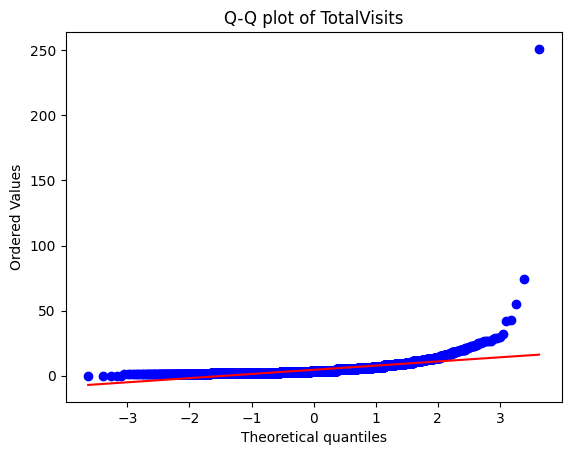

TotalVisits - Shapiro-Wilk test: p-value = 9.370110224028736e-84, Kolmogorov-Smirnov test: p-value = 0.0


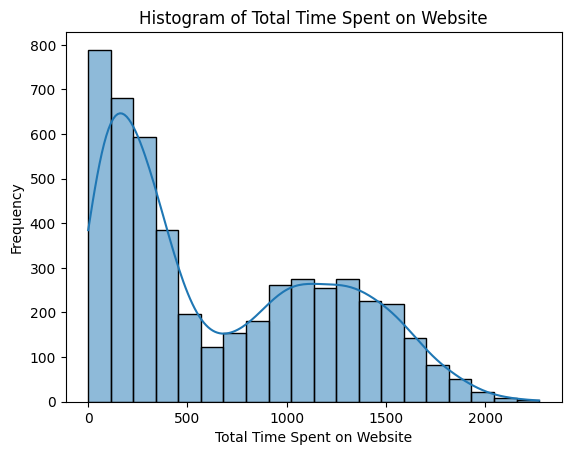

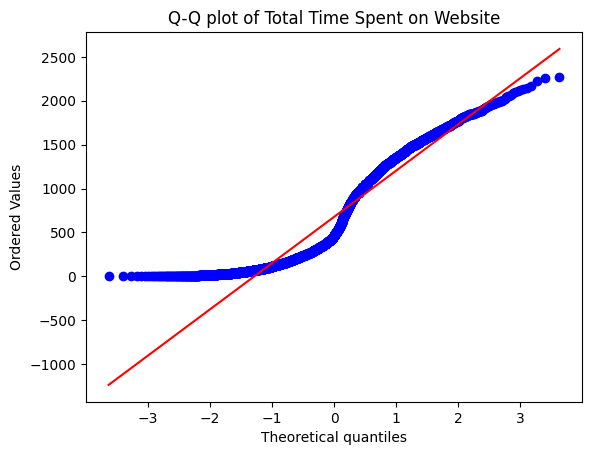

Total Time Spent on Website - Shapiro-Wilk test: p-value = 8.562837133383363e-49, Kolmogorov-Smirnov test: p-value = 0.0


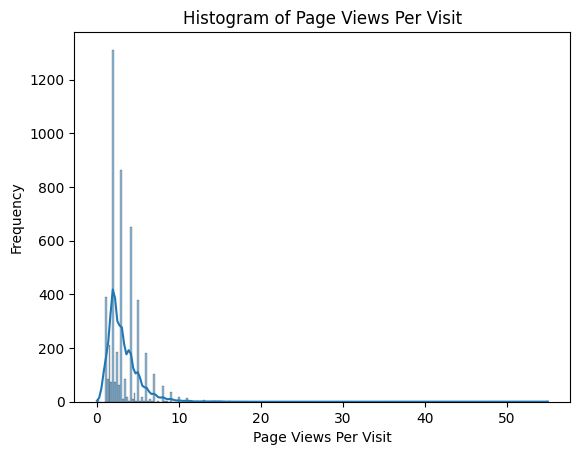

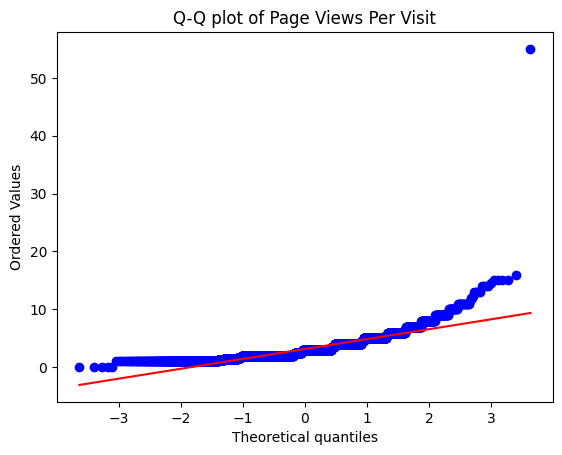

Page Views Per Visit - Shapiro-Wilk test: p-value = 4.09786674876626e-65, Kolmogorov-Smirnov test: p-value = 0.0


In [10]:
# Numerical features
numerical_columns = ['TotalVisits', 'Total Time Spent on Website', 'Page Views Per Visit']

# Checking normal distribution
for column in numerical_columns:
    # Histogram
    plt.figure()
    sns.histplot(lead_data_dropped[column].dropna(), kde=True)
    plt.title(f'Histogram of {column}')
    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.show()
    
    # Q-Q plot
    plt.figure()
    stats.probplot(lead_data_dropped[column].dropna(), dist="norm", plot=plt)
    plt.title(f'Q-Q plot of {column}')
    plt.show()
    
    # Shapiro-Wilk test and Kolmogorov-Smirnov test
    data = lead_data_dropped[column].dropna()
    shapiro_test = shapiro(data)
    ks_test = kstest(data, 'norm')
    print(f"{column} - Shapiro-Wilk test: p-value = {shapiro_test.pvalue}, Kolmogorov-Smirnov test: p-value = {ks_test.pvalue}")


Since our numerical data is not Normally Distributed we have to check/clean outliers using IQR method.

In [11]:
# IQR method (does not assume normal distribution)
Q1 = lead_data_dropped[numerical_columns].quantile(0.25)
Q3 = lead_data_dropped[numerical_columns].quantile(0.75)
IQR = Q3 - Q1
outliers_iqr = (lead_data_dropped[numerical_columns] < (Q1 - 1.5 * IQR)) | (lead_data_dropped[numerical_columns] > (Q3 + 1.5 * IQR))
outliers_iqr_sum = outliers_iqr.sum(axis=1)
outliers_iqr = lead_data_dropped[outliers_iqr_sum > 0]
print("Outliers detected by IQR method:")
print(outliers_iqr)

Outliers detected by IQR method:
                               Prospect ID  Lead Number  \
10    2a369e35-ca95-4ca9-9e4f-9d27175aa320       660608   
12    8bf76a52-2478-476b-8618-1688e07874ad       660562   
56    59e722da-edff-43d9-af61-f5c8bcc986c4       659998   
57    171defdc-6c7b-4486-9a3b-527de447d2d5       659963   
58    d93bfdc0-4719-4f0a-ad6b-31070823dfbb       659942   
...                                    ...          ...   
9129  65b38b58-d76f-4269-a194-d8e7c39eee59       580407   
9132  6642edff-47b7-4548-8974-3dbea0789e70       580401   
9138  2e9f60dd-3ed7-48da-b1de-2f8747e026b1       580373   
9229  5cfdd915-d5a0-4976-b38d-e5f72ec55526       579712   
9233  3f715465-2546-47cd-afa8-8b8dc63b8b43       579622   

                  Lead Origin     Lead Source Do Not Email Do Not Call  \
10    Landing Page Submission  Organic Search           No          No   
12                        API  Organic Search           No          No   
56    Landing Page Submission  Refer

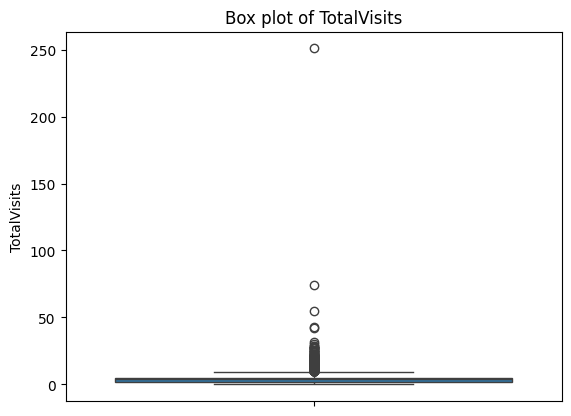

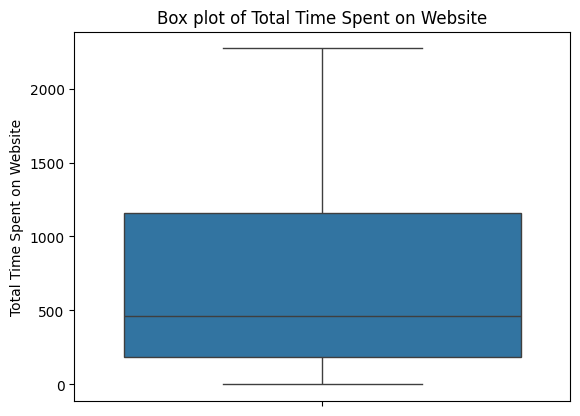

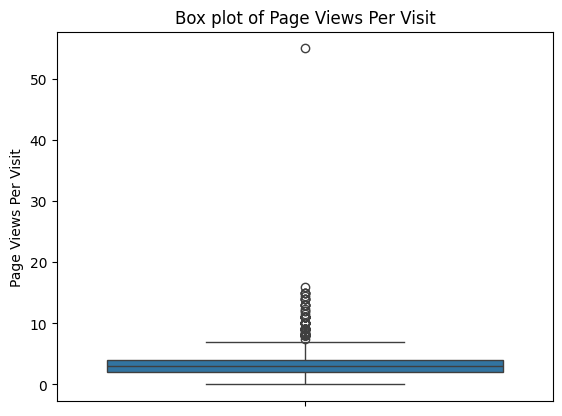

In [12]:
# Visualizations
# Box plots for numerical variables
for column in numerical_columns:
    plt.figure()
    sns.boxplot(data=lead_data_dropped[column])
    plt.title(f'Box plot of {column}')
    plt.show()

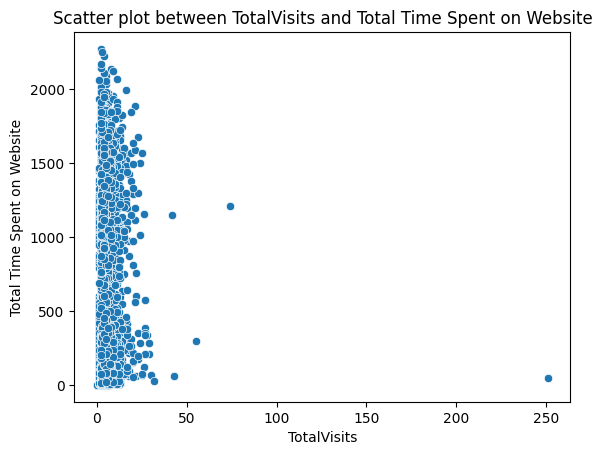

In [13]:
# Scatter plot to visualize outliers
plt.figure()
sns.scatterplot(x='TotalVisits', y='Total Time Spent on Website', data=lead_data_dropped)
plt.title('Scatter plot between TotalVisits and Total Time Spent on Website')
plt.show()

In [14]:
# Understanding the high value in each numerical column
lead_data_dropped.loc[lead_data_dropped['TotalVisits'] > 200]

,Prospect ID,Lead Number,Lead Origin,Lead Source,Do Not Email,Do Not Call,Converted,TotalVisits,Total Time Spent on Website,Page Views Per Visit,...,Digital Advertisement,Through Recommendations,Receive More Updates About Our Courses,Update me on Supply Chain Content,Get updates on DM Content,Lead Profile,City,I agree to pay the amount through cheque,A free copy of Mastering The Interview,Last Notable Activity
6102,f787f694-b4c4-4763-a4ae-9f39a0a052b6,602958,Landing Page Submission,Direct Traffic,No,No,1,251.0,49,1.48,...,No,No,No,No,No,Select,Mumbai,No,Yes,Page Visited on Website


In [15]:
lead_data_dropped.loc[lead_data_dropped['Total Time Spent on Website'] > 2000]

,Prospect ID,Lead Number,Lead Origin,Lead Source,Do Not Email,Do Not Call,Converted,TotalVisits,Total Time Spent on Website,Page Views Per Visit,...,Digital Advertisement,Through Recommendations,Receive More Updates About Our Courses,Update me on Supply Chain Content,Get updates on DM Content,Lead Profile,City,I agree to pay the amount through cheque,A free copy of Mastering The Interview,Last Notable Activity
819,638fecaf-4479-4dd0-8785-cfb9e492d817,651807,Landing Page Submission,Google,No,No,1,11.0,2069,5.5,...,No,No,No,No,No,Select,Mumbai,No,Yes,Email Opened
1388,a69a81be-f69a-45e0-9857-1f75ec740108,645388,API,Google,No,No,1,2.0,2020,2.0,...,No,No,No,No,No,Select,Select,No,No,Email Opened
1675,264b9c84-e4f6-45e9-9caa-93aa4ed8facc,643053,Landing Page Submission,Google,No,No,1,8.0,2137,8.0,...,No,No,No,No,No,Select,Mumbai,No,No,SMS Sent
3113,15b8b16b-b728-4417-b524-bb9d30346a97,630010,Landing Page Submission,Direct Traffic,No,No,1,4.0,2094,4.0,...,No,No,No,No,No,Select,Mumbai,No,Yes,SMS Sent
3518,b39f4976-0479-49c7-a452-0dbc2aa45064,626815,Landing Page Submission,Google,No,No,0,5.0,2090,5.0,...,No,No,No,No,No,Potential Lead,Mumbai,No,No,Modified
3739,6ae8a31b-f96f-40d5-bbaf-49641cad451f,624343,Landing Page Submission,Google,No,No,1,5.0,2037,2.5,...,No,No,No,No,No,Potential Lead,Thane & Outskirts,No,No,Modified
4578,00d914d6-6588-4686-9c63-0049dbb8260c,615877,Landing Page Submission,Google,No,No,1,4.0,2111,4.0,...,No,No,No,No,No,Select,Mumbai,No,No,SMS Sent
5671,623bc6c9-9184-4437-b38f-d374be49d1a3,606508,API,Organic Search,No,No,1,9.0,2125,3.0,...,No,No,No,No,No,Potential Lead,Select,No,No,SMS Sent
5979,1466faae-deac-4c40-8182-f78d717bd74e,603989,API,Google,No,No,1,2.0,2013,2.0,...,No,No,No,No,No,Select,Select,No,No,Email Opened
6314,fea03509-6acc-499b-96f9-8218a4c2d272,601447,Landing Page Submission,Direct Traffic,No,No,0,2.0,2272,2.0,...,No,No,No,No,No,Select,Mumbai,No,Yes,SMS Sent


In [16]:
lead_data_dropped.loc[lead_data_dropped['Page Views Per Visit'] > 20]

,Prospect ID,Lead Number,Lead Origin,Lead Source,Do Not Email,Do Not Call,Converted,TotalVisits,Total Time Spent on Website,Page Views Per Visit,...,Digital Advertisement,Through Recommendations,Receive More Updates About Our Courses,Update me on Supply Chain Content,Get updates on DM Content,Lead Profile,City,I agree to pay the amount through cheque,A free copy of Mastering The Interview,Last Notable Activity
2190,0e4c0711-6cb5-455d-8e0d-7f9f2cc4f895,638668,Landing Page Submission,Direct Traffic,Yes,No,0,55.0,297,55.0,...,No,No,No,No,No,Select,Other Cities,No,Yes,Modified


Some outliers seems to be real and not an error, because of that I'll not remove.

*Obs: Page per views is the only column that seems to have an error, probably it's an system inputation error because is almost impossible visit 55 pages (mean) in an website per visit.*

In [17]:
# Removing > 20 Page Views Per Visit
lead_data_treated = lead_data_dropped.loc[lead_data_dropped['Page Views Per Visit'] < 20]

In [18]:
# Checking
lead_data_treated.loc[lead_data_treated['Page Views Per Visit'] > 20]

,Prospect ID,Lead Number,Lead Origin,Lead Source,Do Not Email,Do Not Call,Converted,TotalVisits,Total Time Spent on Website,Page Views Per Visit,...,Digital Advertisement,Through Recommendations,Receive More Updates About Our Courses,Update me on Supply Chain Content,Get updates on DM Content,Lead Profile,City,I agree to pay the amount through cheque,A free copy of Mastering The Interview,Last Notable Activity


### Feature Engineering

In [19]:
# Interaction Features
lead_data_treated['Visits_PageViews_Interaction'] = lead_data_treated['TotalVisits'] * lead_data_treated['Page Views Per Visit']

# Binary Flags
lead_data_treated['High_Time_Spent'] = lead_data_treated['Total Time Spent on Website'] > 1000

# Aggregated Features
country_visits_avg = lead_data_treated.groupby('Country')['TotalVisits'].transform('mean')
lead_data_treated['Country_Visits_Avg'] = country_visits_avg

# Categorical Interaction
lead_data_treated['Source_Activity'] = lead_data_treated['Lead Source'] + '_' + lead_data_treated['Last Activity']

# Encoding binary flag as integer
lead_data_treated['High_Time_Spent'] = lead_data_treated['High_Time_Spent'].astype(int)

/var/folders/mv/0n_bm_b53q5gmwqrz731m2xc0000gn/T/ipykernel_22328/3406526621.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lead_data_treated['Visits_PageViews_Interaction'] = lead_data_treated['TotalVisits'] * lead_data_treated['Page Views Per Visit']
/var/folders/mv/0n_bm_b53q5gmwqrz731m2xc0000gn/T/ipykernel_22328/3406526621.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lead_data_treated['High_Time_Spent'] = lead_data_treated['Total Time Spent on Website'] > 1000
/var/folders/mv/0n_bm_b53q5gmwqr

### Encoding Data

In [20]:
# Dropping the 'Prospect ID' column from the dataset before encoding
lead_data_for_encoding = lead_data_treated.drop(columns=['Prospect ID'])

# Applying one-hot encoding to the remaining categorical variables
lead_data_encoded = pd.get_dummies(lead_data_for_encoding, drop_first=True)

# Display the shape and first few rows of the encoded dataset
lead_data_encoded.info(), lead_data_encoded.head()

<class 'pandas.core.frame.DataFrame'>
Index: 4924 entries, 1 to 9239
Columns: 210 entries, Lead Number to Source_Activity_testone_Page Visited on Website
dtypes: bool(202), float64(4), int64(4)
memory usage: 1.3 MB


(None,
    Lead Number  Converted  TotalVisits  Total Time Spent on Website  \
 1       660728          0          5.0                          674   
 2       660727          1          2.0                         1532   
 3       660719          0          1.0                          305   
 4       660681          1          2.0                         1428   
 6       660673          1          2.0                         1640   
 
    Page Views Per Visit  Visits_PageViews_Interaction  High_Time_Spent  \
 1                   2.5                          12.5                0   
 2                   2.0                           4.0                1   
 3                   1.0                           1.0                0   
 4                   1.0                           2.0                1   
 6                   2.0                           4.0                1   
 
    Country_Visits_Avg  Lead Origin_Landing Page Submission  \
 1            4.602583                      

### Correlations

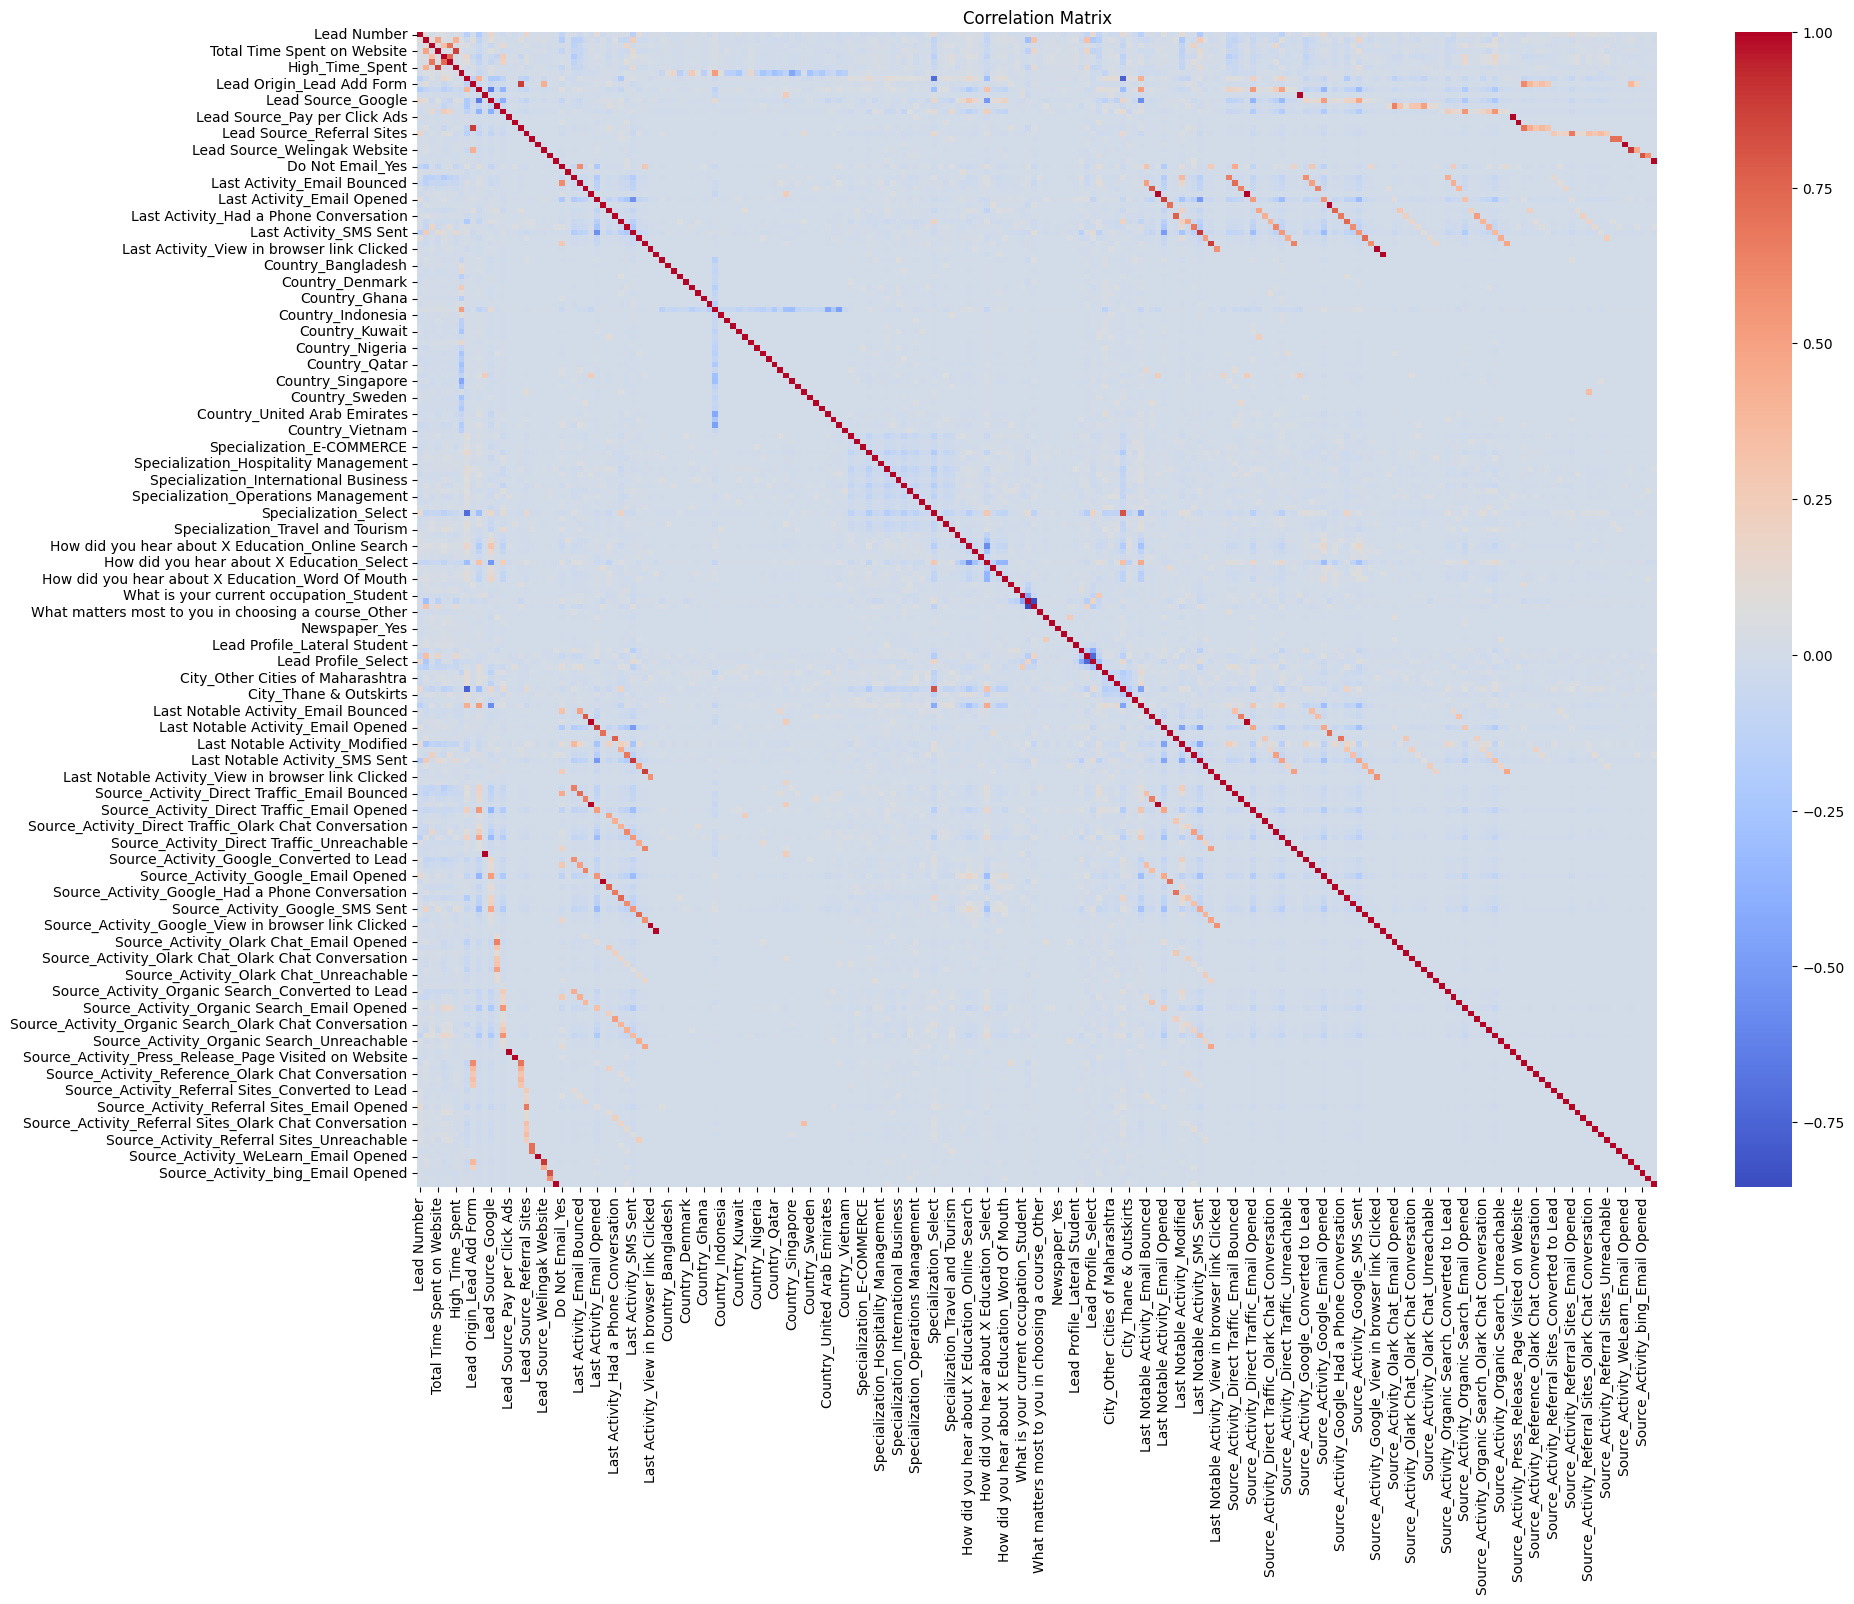

In [21]:
# Correlation analysis
correlation_matrix = lead_data_encoded.corr()

# Plotting the correlation matrix
plt.figure(figsize=(20, 15))
sns.heatmap(correlation_matrix, cmap='coolwarm', annot=False, fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

In [22]:
# Extract features with high correlation to the target variable 'Converted'
correlation_with_target = correlation_matrix['Converted'].sort_values(ascending=False)

# Select features with correlation above a threshold (e.g., |0.1|)
important_features = correlation_with_target[abs(correlation_with_target) > 0.1].index.tolist()

# Display important features and their correlation with the target variable
important_features_correlation = correlation_with_target[important_features]

important_features_correlation

Converted                                               1.000000
Total Time Spent on Website                             0.493090
High_Time_Spent                                         0.416857
Lead Profile_Potential Lead                             0.339564
What is your current occupation_Working Professional    0.314652
Last Notable Activity_SMS Sent                          0.263530
Last Activity_SMS Sent                                  0.251176
Source_Activity_Google_SMS Sent                         0.194079
Lead Source_Direct Traffic                             -0.100849
Specialization_Select                                  -0.103149
Source_Activity_Direct Traffic_Email Bounced           -0.105532
Last Activity_Email Bounced                            -0.132941
Last Activity_Converted to Lead                        -0.138444
Lead Profile_Student of SomeSchool                     -0.157758
Do Not Email_Yes                                       -0.166749
Lead Profile_Select      

### Checking target distribuiton before split

0 Percentage: 55.77%
1 Percentage: 44.23%


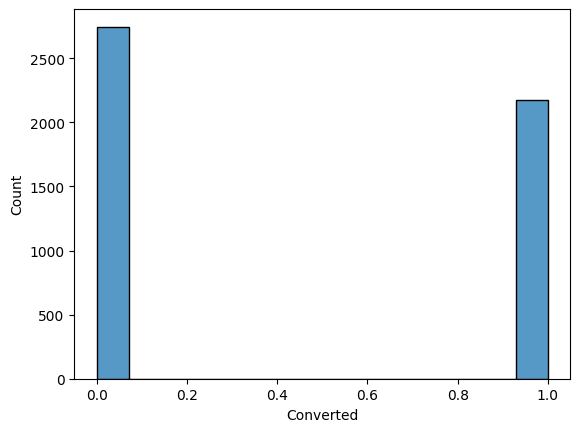

In [23]:
sns.histplot(lead_data_encoded['Converted'])

# Calculate the percentage of each class in the target column
total_count = len(lead_data_encoded)
count_0 = lead_data_encoded.loc[lead_data_encoded['Converted'] == 0].shape[0]
count_1 = lead_data_encoded.loc[lead_data_encoded['Converted'] == 1].shape[0]

percentage_0 = (count_0 / total_count) * 100
percentage_1 = (count_1 / total_count) * 100

print(f'0 Percentage: {percentage_0:.2f}%')
print(f'1 Percentage: {percentage_1:.2f}%')

### Splitting and Scaling Data

In [24]:
# Separate features and target
X = lead_data_encoded.drop(['Converted'], axis=1)
y = lead_data_encoded['Converted']

# Split the data into train, validation, and test sets
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.20, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42, stratify=y_train_val)

# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

joblib.dump(scaler, '../weights/scaler.pkl')
joblib.dump(X_train.columns, '../weights/expected_columns.pkl')

['expected_columns.pkl']

### Checking Labels Distribution

Training Set - 0 Percentage: 55.79%
Training Set - 1 Percentage: 44.21%


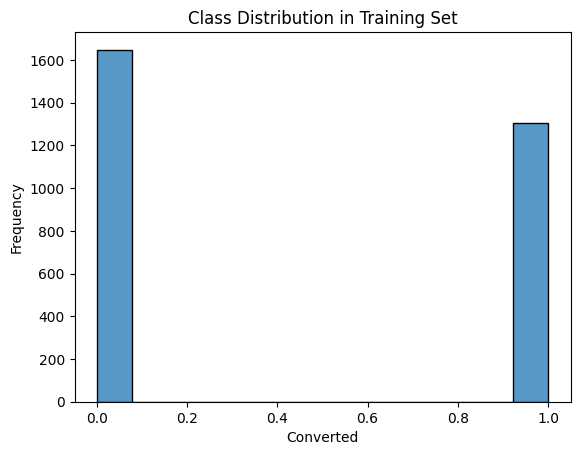

Validation Set - 0 Percentage: 55.74%
Validation Set - 1 Percentage: 44.26%


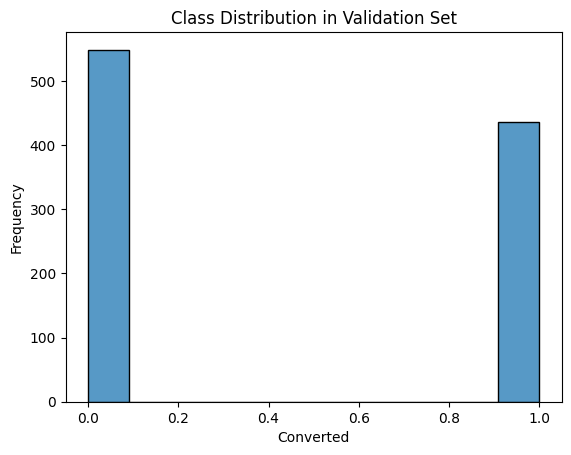

Test Set - 0 Percentage: 55.74%
Test Set - 1 Percentage: 44.26%


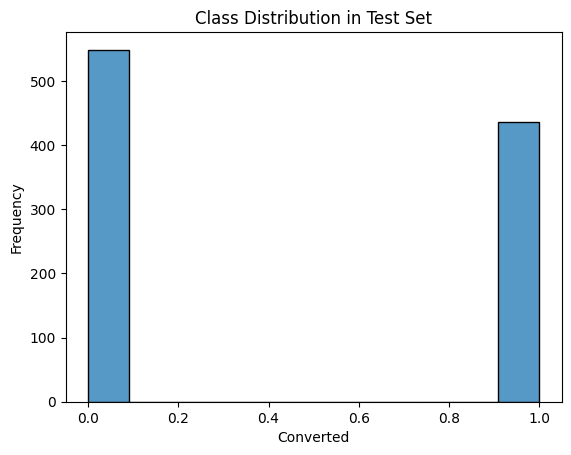

In [25]:
# Calculate and visualize class distribution for training set
calculate_class_distribution(y_train, 'Training Set')

# Calculate and visualize class distribution for validation set
calculate_class_distribution(y_val, 'Validation Set')

# Calculate and visualize class distribution for test set
calculate_class_distribution(y_test, 'Test Set')

Distributions seems pretty similar, lets train some models

## Experimenting with Logistic Regression

In [26]:
# Initialize and train logistic regression model
log_reg = LogisticRegression(max_iter=10000, random_state=42)
log_reg.fit(X_train_scaled, y_train)

LogisticRegression(max_iter=10000, random_state=42)

In [27]:
# Evaluate the model on the train set
y_train_pred = log_reg.predict(X_train_scaled)
y_train_pred_proba = log_reg.predict_proba(X_train_scaled)[:, 1]

In [28]:
# Evaluate the model on the validation set
y_val_pred = log_reg.predict(X_val_scaled)
y_val_pred_proba = log_reg.predict_proba(X_val_scaled)[:, 1]

In [29]:
# Evaluate the model on the test set
y_test_pred = log_reg.predict(X_test_scaled)
y_test_pred_proba = log_reg.predict_proba(X_test_scaled)[:, 1]

In [30]:
# Calculate and print metrics for training set
y_train_pred_proba = log_reg.predict_proba(X_train_scaled)[:, 1]
print_classification_metrics(y_train, y_train_pred, y_train_pred_proba, 'Training Set')

# Calculate and print metrics for validation set
y_val_pred_proba = log_reg.predict_proba(X_val_scaled)[:, 1]
print_classification_metrics(y_val, y_val_pred, y_val_pred_proba, 'Validation Set')

# Calculate and print metrics for test set
y_test_pred_proba = log_reg.predict_proba(X_test_scaled)[:, 1]
print_classification_metrics(y_test, y_test_pred, y_test_pred_proba, 'Test Set')

Training Set - Accuracy: 0.83
Training Set - ROC-AUC: 0.91
Training Set - Confusion Matrix:
[[1426  222]
 [ 286 1020]]
Training Set - Precision: 0.82
Training Set - Recall: 0.78
Training Set - F1-Score: 0.80

Validation Set - Accuracy: 0.81
Validation Set - ROC-AUC: 0.88
Validation Set - Confusion Matrix:
[[466  83]
 [106 330]]
Validation Set - Precision: 0.80
Validation Set - Recall: 0.76
Validation Set - F1-Score: 0.78

Test Set - Accuracy: 0.82
Test Set - ROC-AUC: 0.88
Test Set - Confusion Matrix:
[[469  80]
 [102 334]]
Test Set - Precision: 0.81
Test Set - Recall: 0.77
Test Set - F1-Score: 0.79



In [31]:
# Model interpretability - Feature Importance
feature_names = X_train.columns
coefficients = log_reg.coef_[0]
feature_importance = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefficients})
feature_importance['Absolute Coefficient'] = np.abs(feature_importance['Coefficient'])
sorted_feature_importance = feature_importance.sort_values(by='Absolute Coefficient', ascending=False)
print("Top 10 Important Features:\n", sorted_feature_importance.head(10))

Top 10 Important Features:
                                         Feature  Coefficient  \
2                   Total Time Spent on Website     1.191073   
113                         Lead Profile_Select    -1.185116   
114          Lead Profile_Student of SomeSchool    -0.786213   
102  What is your current occupation_Unemployed    -0.656455   
1                                   TotalVisits     0.625562   
111                    Lead Profile_Other Leads    -0.531928   
0                                   Lead Number     0.506377   
23                             Do Not Email_Yes    -0.424276   
4                  Visits_PageViews_Interaction    -0.419214   
131              Last Notable Activity_SMS Sent     0.328920   

     Absolute Coefficient  
2                1.191073  
113              1.185116  
114              0.786213  
102              0.656455  
1                0.625562  
111              0.531928  
0                0.506377  
23               0.424276  
4              

### Model Interpretability: Feature Importance

For logistic regression, the coefficients of the model can provide insights into the importance and impact of each feature. A positive coefficient increases the log-odds of the target being 1 (i.e., lead converting), whereas a negative coefficient decreases it.

Top 10 features that influence the likelihood of a lead converting, based on the absolute values of their coefficients in the logistic regression model:

1. **Lead Profile - Select**: Negatively impacts the likelihood of conversion.
2. **Total Time Spent on Website**: Positively impacts conversion likelihood; more time on site indicates higher engagement.
3. **Lead Profile - Student of SomeSchool**: Negatively impacts the likelihood of conversion.
4. **Current Occupation - Working Professional**: Positively impacts conversion likelihood, suggesting that working professionals are more likely to convert.
5. **Lead Number**: Positively impacts conversion likelihood, though this might be more of a data artifact.
6. **Lead Profile - Other Leads**: Negatively impacts the likelihood of conversion.
7. **Last Activity - Email Opened**: Negatively impacts the likelihood of conversion.
8. **Last Notable Activity - SMS Sent**: Positively impacts conversion likelihood, indicating effective SMS marketing.
9. **Last Activity - Converted to Lead**: Negatively impacts conversion likelihood.
10. **Last Activity - Email Bounced**: Negatively impacts the likelihood of conversion.

In [32]:
# Generate lead scores for a sample of test data
test_probabilities = log_reg.predict_proba(X_test_scaled)[:, 1]
lead_scores = pd.DataFrame({
    'Actual Conversion': y_test,
    'Predicted Probability (Score)': test_probabilities
})
print("Sample Lead Scores:\n", lead_scores.sample(10))

Sample Lead Scores:
       Actual Conversion  Predicted Probability (Score)
710                   0                       0.146291
6843                  1                       0.868341
8751                  0                       0.512699
1630                  1                       0.985051
2740                  0                       0.426019
626                   0                       0.009071
6219                  0                       0.220571
7832                  1                       0.813069
1037                  0                       0.295964
2882                  1                       0.998976


### Experimenting XGBoost with GridSearch and CrossValidation

In [33]:
# Define the parameter grid for GridSearchCV
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'gamma': [0, 0.1, 0.2]
}

# Initialize the GridSearchCV object
grid_search = GridSearchCV(
    estimator=XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
    param_grid=param_grid,
    scoring='roc_auc',
    cv=5,
    verbose=1,
    n_jobs=-1
)

# Fit the grid search to the training data
grid_search.fit(X_train_scaled, y_train)

# Print the best parameters and best score
print(f'Best parameters found: {grid_search.best_params_}')
print(f'Best ROC-AUC score: {grid_search.best_score_}')

Fitting 5 folds for each of 324 candidates, totalling 1620 fits


Best parameters found: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'subsample': 1.0}
Best ROC-AUC score: 0.900706424768356


In [34]:
# Use the best model to make predictions
best_model = grid_search.best_estimator_

# Perform cross-validation on the best model
cv_scores = cross_val_score(best_model, X_train_scaled, y_train, cv=5, scoring='roc_auc', n_jobs=-1)

# Print cross-validation scores
print(f'Cross-validation ROC-AUC scores: {cv_scores}')
print(f'Mean ROC-AUC score: {cv_scores.mean()}')
print(f'Standard deviation of ROC-AUC scores: {cv_scores.std()}')

# Train the best model on the entire training set
best_model.fit(X_train_scaled, y_train)

# Save the trained model
joblib.dump(best_model, '../weights/xgb_model.pkl')

Cross-validation ROC-AUC scores: [0.90500406 0.90357018 0.90289098 0.89364022 0.89842667]
Mean ROC-AUC score: 0.900706424768356
Standard deviation of ROC-AUC scores: 0.0041610470188719545


['xgb_model.pkl']

In [35]:
# Calculate and print metrics for training set
y_train_pred_proba = best_model.predict_proba(X_train_scaled)[:, 1]
print_classification_metrics(y_train, y_train_pred, y_train_pred_proba, 'Training Set')

# Calculate and print metrics for validation set
y_val_pred_proba = best_model.predict_proba(X_val_scaled)[:, 1]
print_classification_metrics(y_val, y_val_pred, y_val_pred_proba, 'Validation Set')

# Calculate and print metrics for test set
y_test_pred_proba = best_model.predict_proba(X_test_scaled)[:, 1]
print_classification_metrics(y_test, y_test_pred, y_test_pred_proba, 'Test Set')

Training Set - Accuracy: 0.83
Training Set - ROC-AUC: 0.93
Training Set - Confusion Matrix:
[[1426  222]
 [ 286 1020]]
Training Set - Precision: 0.82
Training Set - Recall: 0.78
Training Set - F1-Score: 0.80

Validation Set - Accuracy: 0.81
Validation Set - ROC-AUC: 0.91
Validation Set - Confusion Matrix:
[[466  83]
 [106 330]]
Validation Set - Precision: 0.80
Validation Set - Recall: 0.76
Validation Set - F1-Score: 0.78

Test Set - Accuracy: 0.82
Test Set - ROC-AUC: 0.91
Test Set - Confusion Matrix:
[[469  80]
 [102 334]]
Test Set - Precision: 0.81
Test Set - Recall: 0.77
Test Set - F1-Score: 0.79



Metrics are pretty similar, no indication of overfitting

### Model Interpretation (SHAP)

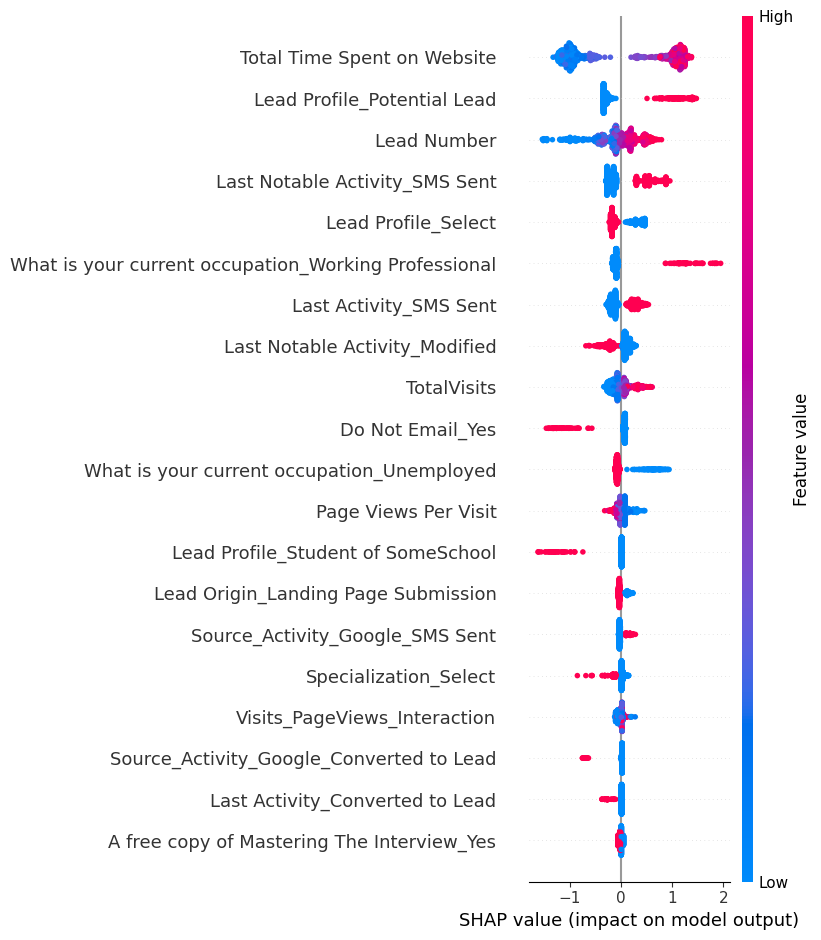

In [36]:
# Compute SHAP values
explainer = shap.Explainer(best_model, X_train_scaled)
shap_values = explainer(X_test_scaled)

# SHAP summary plot
shap.summary_plot(shap_values, X_test, feature_names=X.columns)

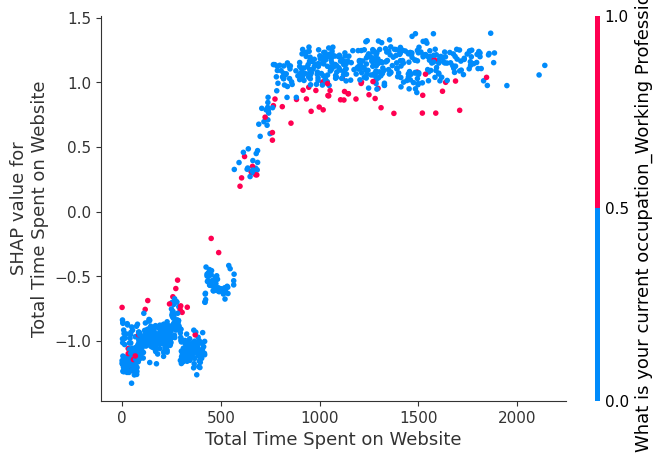

In [37]:
# SHAP dependence plot for a specific feature
shap.dependence_plot('Total Time Spent on Website', shap_values.values, X_test, feature_names=X.columns)

In [38]:
shap.plots.initjs()

In [39]:
# SHAP force plot for the first instance in the test set
shap.force_plot(explainer.expected_value, shap_values.values[1], X_test.iloc[1], feature_names=X.columns)

In [40]:
# Transforming log-odds to the usual probability scale (0-1)
log_odds_prediction = explainer.expected_value + np.sum(shap_values.values[1])
probability_prediction = log_odds_to_probability(log_odds_prediction)
print(f'Log-Odds Prediction: {log_odds_prediction}')
print(f'Probability Prediction: {probability_prediction}')

Log-Odds Prediction: -1.5318038831379626
Probability Prediction: 0.177729909445448
